1.
Using R in two separate code chunks, import the Chicago Food Inspections Data and the US Natality Data (parts 1 and 2) with the URL. Rename the data objects as “food” and “birth” respectively.

In [1]:
options errors=5

SAS Connection established. Subprocess id is 2743



In [2]:
filename chic url "https://uofi.box.com/shared/static/5637axblfhajotail80yw7j2s4r27hxd.csv";

data food;
length DBAName $50. AKAName $50. FacilityType $50. Risk $50. Address $60. InspectionType $80. 
       Results $30. Violations $2000. ;
infile chic dsd firstobs=2;
input InspectionID DBAName $ AKAName $ LicenseNum 
      FacilityType $ Risk $ Address $ City $ State $
      Zip InspectionDate :mmddyy10. InspectionType $
      Results $ Violations $ Latitude Longitude;
format InspectionDate mmddyy10.;
run;

In [6]:
filename nat1 url "https://uofi.box.com/shared/static/gb07nz7jafspk65wzxq6awlu02kypiq7.csv" termstr=crlf;
filename nat2 url "https://uofi.box.com/shared/static/kr2s5wp3jpxdlpcjmq2qs15oo4797u4y.csv" termstr=crlf;
proc import datafile=nat1 out=birth01(keep=sex dplural mager9 meduc dbwt
                                           CA_ANEN CA_MNSB CA_CCHD CA_CDH
                                           CA_OMPH CA_GAST CA_LIMB CA_CLEFT
                                           CA_CLPAL CA_DOWN CA_DISOR CA_HYPO) replace dbms=csv; 
run;
proc import datafile=nat2 out=birth02(keep=sex dplural mager9 meduc dbwt
                                           CA_ANEN CA_MNSB CA_CCHD CA_CDH
                                           CA_OMPH CA_GAST CA_LIMB CA_CLEFT
                                           CA_CLPAL CA_DOWN CA_DISOR CA_HYPO) replace dbms=csv; 
run;

data birth;
 set birth01 birth02;
 if dplural = 2 then
     twins = 1;
 if dplural ne 2 then
     twins = 0;
 if ca_anen = "Y" or CA_MNSB = "Y" or CA_CCHD = "Y" or CA_CDH = "Y"
     or CA_OMPH = "Y" or CA_GAST = "Y" or CA_LIMB = "Y" or CA_CLEFT = "Y"
     or CA_CLPAL = "Y" or CA_DOWN = "Y" or CA_DISOR = "Y" or CA_HYPO = "Y" then
         anomaly = 1;
 else
     anomaly = 0;
 where dbwt ne 9999;
run;

2.

I want to do an analysis that focuses on babies born as twins (aka “twinsies”). . The variable of interest for determining twin is the plurality recode (DPLURAL). The Problems (of the Investigative Cycle) are:

- How do babies assigned female compare to babies assigned male at birth among the twinsies?
- How well can we predict whether a baby is born as a twin or not based on mother’s education level, mother’s age, baby’s birth weight in grams, and whether the baby has a congenital anomaly or not?
- Which predictors improve prediction of a twin baby’s birth weight?


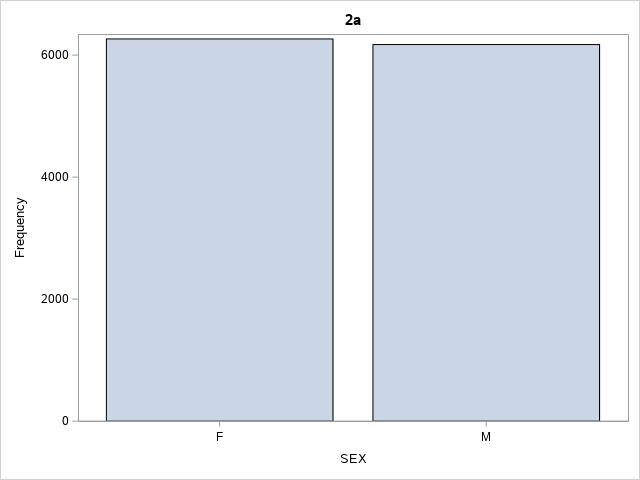

In [13]:
title "2a";

proc sgplot data=birth;
 where twins = 1;
 vbar sex / groupdisplay=cluster;
run;
title ;

Looking at the plot above, we can see that when looking at twins only that female and male are assigned to babies at birth at very similar amounts. Female assignments are slightly higher than male, but overall they are mostly equal.

In [14]:
proc logistic data=birth plots=influence;
 class anomaly mager9 meduc / param=ref ref=first;
 model twins(event="1") = anomaly mager9 meduc dbwt / rsquare;
 output out=predz predprobs=individual;
 ods select association rsquare;
run;

In [17]:
proc sort data=predz;
 by descending twins descending _INTO_ ;
run;
proc freq data=predz order=data;
 table _INTO_*twins / nocol nocum nopercent norow out=confmat;
run;
data confmat;
 set confmat;
 match=0;
 if twins=_INTO_ then match=1;
 run;
proc means data=confmat mean;
 freq count;
 var match;
run;

Looking at the output above, our model can predict whether a baby is born as a twin based on the given predictors quite well. We have an accuracy rate of ~.965 or 96.5%. However, judging by the confusion matrix our model is heavily misclassifying those that are truly twins as not twins a large amount of times. This tells me that the model is mostly classifying all observations as not twins.

For part c, I will be using stepwise selection in order to figure out which predictors improve prediction of a twin baby's birth weight.

In [22]:
data twin_baby;
    set birth;
    if twins = 1;
    if sex = "M" then
        sexr = 1;
    else
        sexr = 0;
run;

In [27]:
proc reg data=twin_baby;
 model dbwt = sexr anomaly mager9 meduc / selection=stepwise sle=0.05 sls=0.05;
 ods select selectionsummary;
run;

Looking at the output above of the stepwise selection, we end up with *sexr*, *mager9*, and *anomaly* as the predictors that improve prediction of a twin baby's birth weight. Note that these variables are the sex of the baby, mothers age, and whether the baby had an anomaly. 

3.

Consider the models you used in answering questions about prediction in Problem 2 and decide on a more parsimonious model. Explain why it is a good model for that response. There are (at least) 2 different models to consider in Problem 2.

For this question, I will be using a KNN classifier rather than logistic regression for predicting if a baby is a twin or not. I believe that KNN will offer more generalization to the problem due to being a nonparametric method.

In [28]:
proc discrim data=birth method=npar k=3;
 class twins;
 var anomaly mager9 meduc dbwt dbwt;
run;